In [4]:
import pandas as pd
from sklearn import tree
import graphviz

# Preprocessing

In [66]:
# load data from disk (modify the path appropriately)
df = pd.read_excel('Data/FuelEconomy/FuelEconomy.xls')
df.head(3)

,Model,Displ,Cyl,Trans,Drive,Fuel,Sales Area,Stnd,Stnd Description,Underhood ID,Veh Class,Air Pollution Score,City MPG,Hwy MPG,Cmb MPG,Greenhouse Gas Score,SmartWay
0,ACURA MDX,3.7,6.0,SemiAuto-6,4WD,Gasoline,FA,B5,Federal Tier 2 Bin 5,CHNXT03.7R19,SUV,5,16,21,18,3,no
1,ACURA MDX,3.7,6.0,SemiAuto-6,4WD,Gasoline,CA,U2,California LEV-II ULEV,CHNXT03.7R19,SUV,6,16,21,18,3,no
2,ACURA RDX,2.3,4.0,SemiAuto-5,4WD,Gasoline,FA,B5,Federal Tier 2 Bin 5,CHNXT02.3Y19,SUV,5,17,22,19,3,no


In [67]:
# set Model to index
df = df.set_index('Model')
df.head(3)

,Displ,Cyl,Trans,Drive,Fuel,Sales Area,Stnd,Stnd Description,Underhood ID,Veh Class,Air Pollution Score,City MPG,Hwy MPG,Cmb MPG,Greenhouse Gas Score,SmartWay
Model,,,,,,,,,,,,,,,,
ACURA MDX,3.7,6.0,SemiAuto-6,4WD,Gasoline,FA,B5,Federal Tier 2 Bin 5,CHNXT03.7R19,SUV,5,16,21,18,3,no
ACURA MDX,3.7,6.0,SemiAuto-6,4WD,Gasoline,CA,U2,California LEV-II ULEV,CHNXT03.7R19,SUV,6,16,21,18,3,no
ACURA RDX,2.3,4.0,SemiAuto-5,4WD,Gasoline,FA,B5,Federal Tier 2 Bin 5,CHNXT02.3Y19,SUV,5,17,22,19,3,no


In [68]:
# drop columns that are not used
columns_to_drop = ['Sales Area','Stnd','Stnd Description','Underhood ID',
                   'City MPG','Hwy MPG','SmartWay','Greenhouse Gas Score',
                  'Air Pollution Score']
df = df.drop(columns_to_drop,axis=1)
df.head(3)

,Displ,Cyl,Trans,Drive,Fuel,Veh Class,Cmb MPG
Model,,,,,,,
ACURA MDX,3.7,6.0,SemiAuto-6,4WD,Gasoline,SUV,18
ACURA MDX,3.7,6.0,SemiAuto-6,4WD,Gasoline,SUV,18
ACURA RDX,2.3,4.0,SemiAuto-5,4WD,Gasoline,SUV,19


In [69]:
# check data types, note Cmb MGP is not float
df.dtypes

Displ        float64
Cyl          float64
Trans         object
Drive         object
Fuel          object
Veh Class     object
Cmb MPG       object
dtype: object

In [70]:
# convert Cmb MPG to float
df['Cmb MPG'] = pd.to_numeric(df['Cmb MPG'],errors='coerce')
df.dtypes

Displ        float64
Cyl          float64
Trans         object
Drive         object
Fuel          object
Veh Class     object
Cmb MPG      float64
dtype: object

In [71]:
# bin fuel economy
df['Cmb MPG'] = pd.qcut(df['Cmb MPG'],[0,0.5,1],labels=['L','H'])
#s = df['Cmb MPG']
#df['Cmb MPG'] = s.cat.codes
df.head(3)

,Displ,Cyl,Trans,Drive,Fuel,Veh Class,Cmb MPG
Model,,,,,,,
ACURA MDX,3.7,6.0,SemiAuto-6,4WD,Gasoline,SUV,L
ACURA MDX,3.7,6.0,SemiAuto-6,4WD,Gasoline,SUV,L
ACURA RDX,2.3,4.0,SemiAuto-5,4WD,Gasoline,SUV,L


In [72]:
# convert data types
df['Trans'] = df.Trans.astype('category')
df['Drive'] = df.Drive.astype('category')
df['Fuel'] = df.Fuel.astype('category')
df['Veh Class'] = df['Veh Class'].astype('category')
df.dtypes

Displ         float64
Cyl           float64
Trans        category
Drive        category
Fuel         category
Veh Class    category
Cmb MPG      category
dtype: object

In [73]:
# drop vehicles with NaN attributes
print('before:',df.shape)
df = df.dropna()
print('after:',df.shape)
df.head(10)

before: (2264, 7)
after: (1915, 7)


,Displ,Cyl,Trans,Drive,Fuel,Veh Class,Cmb MPG
Model,,,,,,,
ACURA MDX,3.7,6.0,SemiAuto-6,4WD,Gasoline,SUV,L
ACURA MDX,3.7,6.0,SemiAuto-6,4WD,Gasoline,SUV,L
ACURA RDX,2.3,4.0,SemiAuto-5,4WD,Gasoline,SUV,L
ACURA RDX,2.3,4.0,SemiAuto-5,4WD,Gasoline,SUV,L
ACURA RDX,2.3,4.0,SemiAuto-5,2WD,Gasoline,SUV,L
ACURA RDX,2.3,4.0,SemiAuto-5,2WD,Gasoline,SUV,L
ACURA TL,3.5,6.0,SemiAuto-6,2WD,Gasoline,midsize car,H
ACURA TL,3.5,6.0,SemiAuto-6,2WD,Gasoline,midsize car,H
ACURA TL,3.7,6.0,Man-6,4WD,Gasoline,midsize car,L


# Decision Tree

In [79]:
# split data into attributes and target

attributes = df.drop(['Cmb MPG'], axis = 1)

target = df['Cmb MPG']

In [80]:
# one-hot-encode attributes
attributes=pd.get_dummies(attributes) # one-hot-encode categorical attributes

In [81]:
# initialize decision tree
Tree = tree.DecisionTreeClassifier(max_depth = 10)

In [82]:
# fit decision tree
Tree.fit(attributes,target)

DecisionTreeClassifier(max_depth=10)

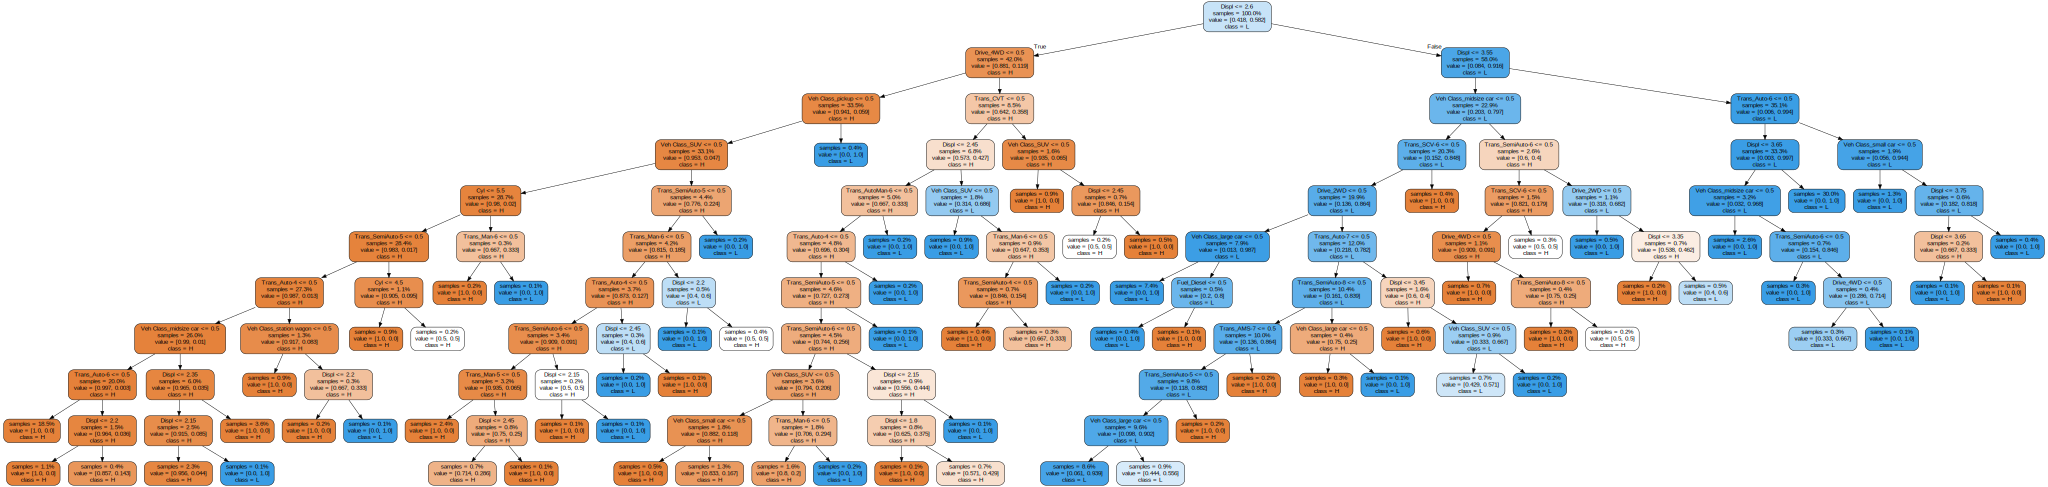

In [83]:
# display decision tree
dot_data = tree.export_graphviz(Tree,
                                out_file=None,
                                feature_names=attributes.columns,
                                class_names=['H','L'],
                                proportion=True,
                                impurity=False,
                                filled=True,
                                rounded=True)
graph = graphviz.Source(dot_data)
# graph.render(’FuelEconomy’) # outputs a PDF file
graph